In [1]:
setwd('/import/DB/zhang//data')
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [2]:
daa = readRDS('./OS.add.copykat.rds')

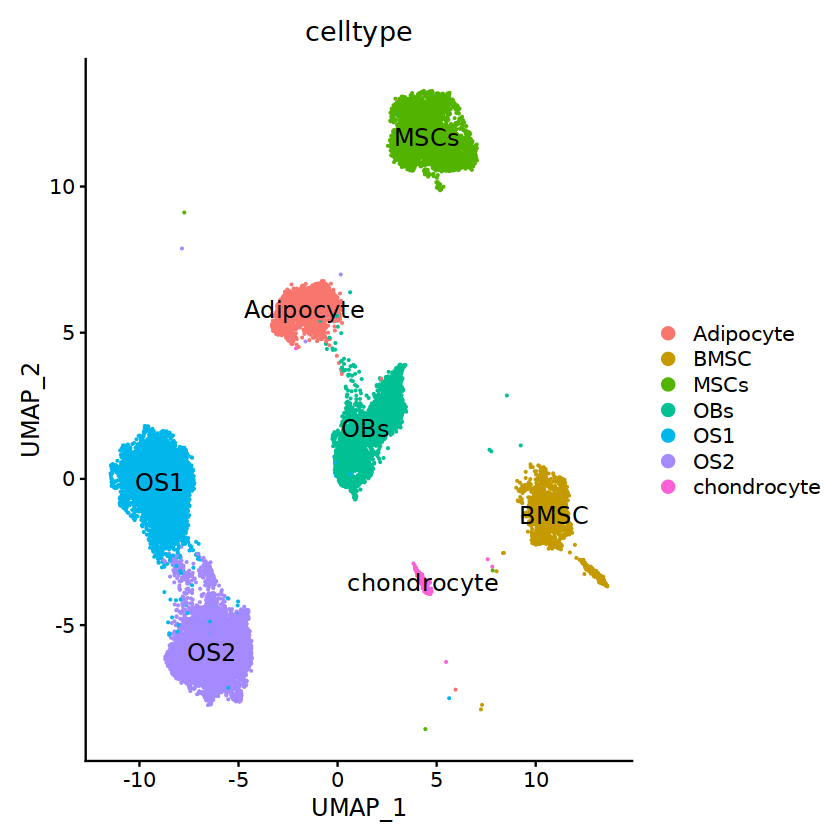

An object of class Seurat 
17360 features across 1702 samples within 1 assay 
Active assay: RNA (17360 features, 0 variable features)

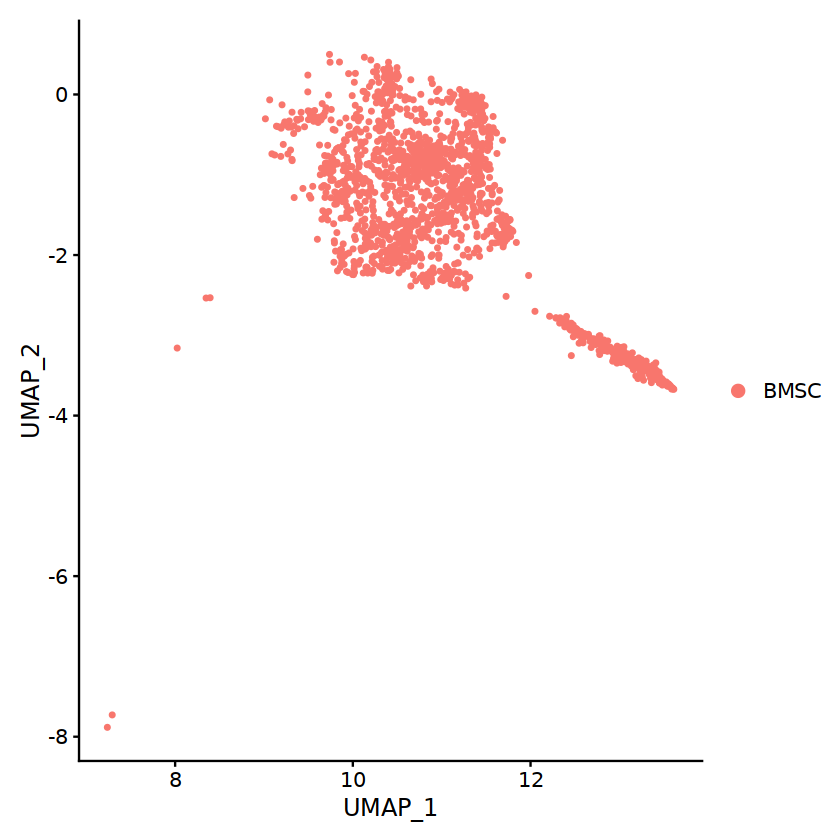

In [3]:
DefaultAssay(daa) = 'RNA'
library(Seurat)
Idents(daa) = 'celltype'
DimPlot(daa, group.by="celltype", label=T, label.size=5, reduction='umap')
OS = subset(daa,celltype =='BMSC')
DimPlot(OS)
mca2=CreateSeuratObject(OS@assays$RNA@data,assay = "RNA",min.cells =5 ,meta.data = OS@meta.data)
immune.combined = mca2
immune.combined

In [4]:
table(immune.combined$group)


     OS control 
    918     784 

In [5]:
Idents(immune.combined) = 'group'

In [6]:
library(Seurat)

In [7]:
DefaultAssay(immune.combined) = 'RNA'

In [8]:
# gene = FindMarkers(immune.combined,ident.1 = 'OS')

# library(dplyr)

# up = gene %>%  filter( avg_log2FC > 0) %>%  rownames()

# down = gene %>%  filter( avg_log2FC < 0) %>%  rownames()

# all =c(up,down)

# go_kegg_func = function(x){
#     library(ggrepel)
#     library(ggplot2)
#     library(cowplot)
#     library(pheatmap)
#     library(enrichplot)
#     library(clusterProfiler)
    
#     library(org.Hs.eg.db)
#     gene_symbol <- bitr(geneID = x,  
#                         fromType="SYMBOL",   
#                         toType=c("ENTREZID"),  
#                         OrgDb="org.Hs.eg.db")
#     gene <- gene_symbol[,2]
#     BP <- enrichGO(gene = gene,  
#                    keyType = "ENTREZID",  
#                    OrgDb=org.Hs.eg.db,  
#                    ont = "BP",   
#                    pvalueCutoff = 1,  
#                    pAdjustMethod = "fdr", 
#                    minGSSize = 5,   
#                    maxGSSize = 500,  
#                    qvalueCutoff = 1,  
#                    readable = TRUE)  
#     dotplot(BP,showCategory = 15)
#     ggsave(paste0(substitute(x),'.GO_enrichment_dotplot.pdf'),height = 15,width = 8)
#     # bp <-clusterProfiler::simplify(BP)
#     # BP_ego <- enrichplot::pairwise_termsim(bp)
#     # emapplot(BP_ego, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
#     #   ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
#     #                         guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
#     # ggsave(paste0(substitute(x),'.GO_enrichment_emapplot.pdf'),height = 15,width = 8)
#     df <- BP@result
#     write.csv(df ,file = paste0(substitute(x),'.GO_results.csv'))
#     ## KEGG
#     ek <- enrichKEGG(gene =gene , 
#                    organism = "hsa",  
#                    pvalueCutoff =1, 
#                    qvalueCutoff = 1) 
#     keggres = ek@result
#     write.csv(keggres,file = paste0(substitute(x),'.kegg_results.csv'))
#     enrichplot::dotplot(ek,  
#             x = "GeneRatio", 
#             color = "p.adjust", 
#             showCategory = 15, 
#             size = 'Count', 
#             title = "KEGG_enrichment_dotplot"  
#             )
#     ggsave(paste0(substitute(x),'.KEGG_enrichment_dotplot.pdf'),height = 6,width = 6)
#     # KEGG2 <- pairwise_termsim(ek)
#     # emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
#     #   ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
#     #                         guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
#     # ggsave(paste0(substitute(x),'.KEGG_enrichment_net.pdf'),height = 8,width = 8)   


    
# }

# go_kegg_func(up)

# go_kegg_func(down)

# go_kegg_func(all)

In [9]:
table(immune.combined$copykat.tumor.pred)


aneuploid   diploid 
      530      1172 

In [10]:
table(immune.combined$group)


     OS control 
    918     784 

In [11]:
table(immune.combined$copykat.tumor.pred)


aneuploid   diploid 
      530      1172 

In [12]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [13]:
immune.combined@meta.data = immune.combined@meta.data %>%
  mutate(cellgroup = case_when(group == 'control'  ~ 'normal_BMSC',
                             group == 'OS' & copykat.tumor.pred == 'diploid' ~ 'Inter_BMSC',
                             TRUE ~ 'tumor_BMSC' ))

In [14]:
table(immune.combined$cellgroup)


 Inter_BMSC normal_BMSC  tumor_BMSC 
        389         784         529 

In [15]:
library(harmony)
DefaultAssay(immune.combined) = 'RNA'
table(OS$orig.ident)
sceList <- SplitObject(immune.combined, split.by = "orig.ident")
single.ob=merge(sceList[[1]],sceList[2:length(sceList)])
DefaultAssay(single.ob) = 'RNA'
scRNA_harmony = single.ob
scRNA_harmony <- NormalizeData(scRNA_harmony) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose=FALSE)
##整合
system.time({scRNA_harmony <- RunHarmony(scRNA_harmony, group.by.vars = "orig.ident")})
scRNA_harmony <- RunUMAP(scRNA_harmony, reduction = "harmony", dims = 1:30)
scRNA_harmony <- RunTSNE(scRNA_harmony, reduction = "harmony", dims = 1:30)
scRNA_harmony <- FindNeighbors(scRNA_harmony, reduction = "harmony", dims = 1:30) %>% FindClusters(resolution =  0.05)
##作图
#group_by_cluster

Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.2.3"



          C1           C2           S1           S2           S3           S4 
           2            4          188          238          125          227 
WH2109002886 WH2109013167 WH2112008442 WH2201006389 WH2203005877 
         356          186           77          244           55 

Centering and scaling data matrix

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


   user  system elapsed 
  1.012   3.797   0.612 

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
08:38:00 UMAP embedding parameters a = 0.9922 b = 1.112

08:38:00 Read 1702 rows and found 30 numeric columns

08:38:00 Using Annoy for neighbor search, n_neighbors = 30

08:38:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:38:00 Writing NN index file to temp file /tmp/Rtmp1wudrT/file37ce123fa65

08:38:00 Searching Annoy index using 1 thread, search_k = 3000

08:38:00 Annoy recall = 100%

08:38:01 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1702
Number of edges: 78118

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9761
Number of communities: 3
Elapsed time: 0 seconds


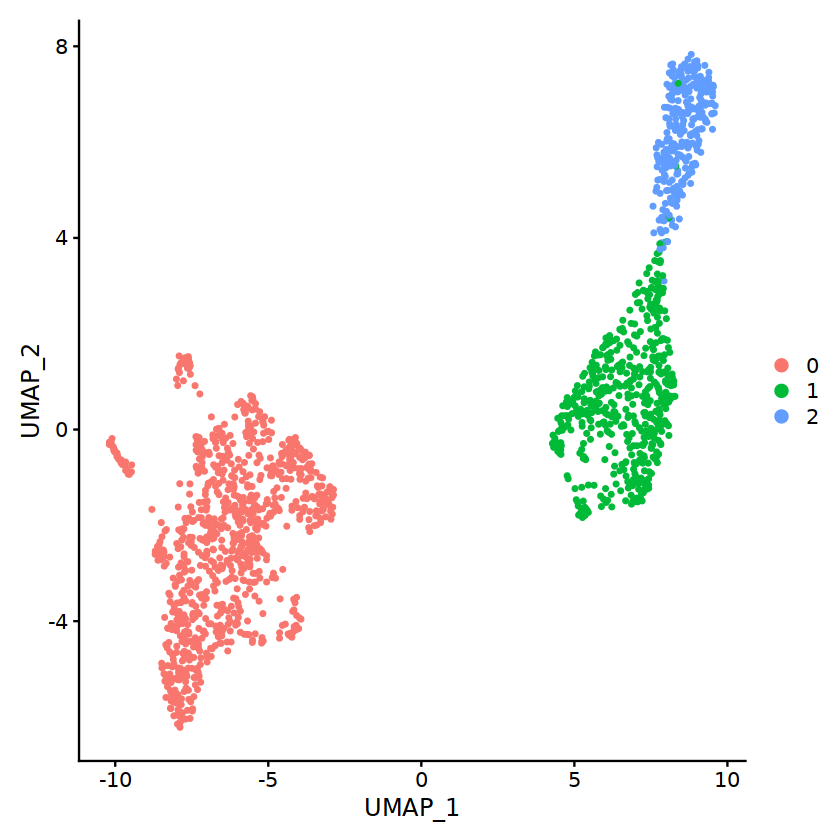

In [16]:
Idents(scRNA_harmony) = 'seurat_clusters'
DimPlot(scRNA_harmony)

In [17]:
table(scRNA_harmony$orig.ident,scRNA_harmony$cellgroup)

              
               Inter_BMSC normal_BMSC tumor_BMSC
  C1                    0           2          0
  C2                    0           4          0
  S1                    0         188          0
  S2                    0         238          0
  S3                    0         125          0
  S4                    0         227          0
  WH2109002886         13           0        343
  WH2109013167          4           0        182
  WH2112008442         73           0          4
  WH2201006389        244           0          0
  WH2203005877         55           0          0

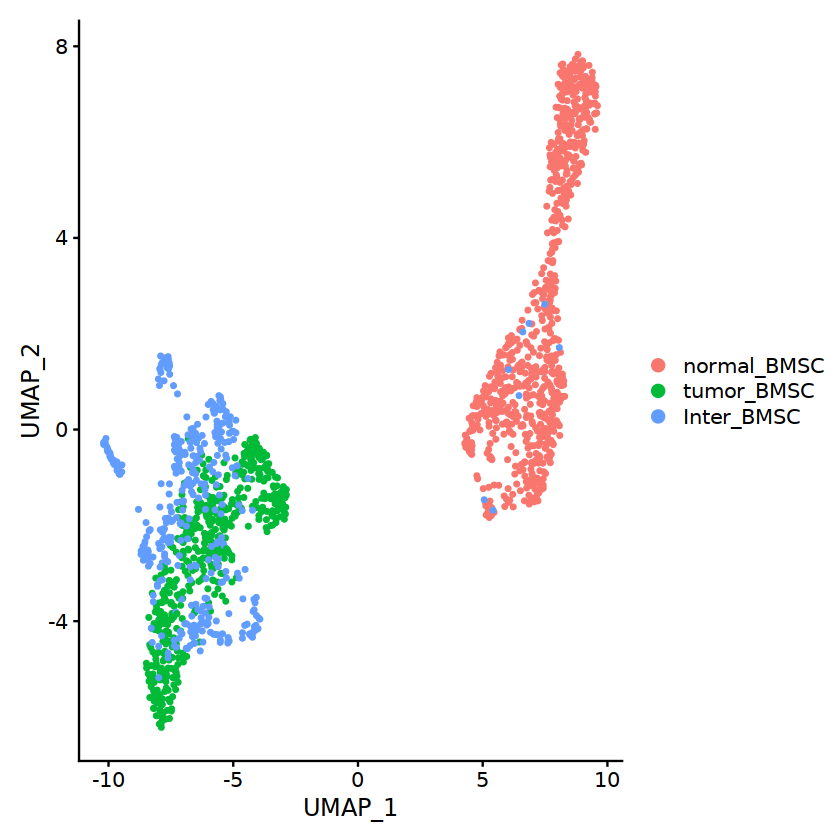

In [18]:
Idents(scRNA_harmony) = 'cellgroup'
DimPlot(scRNA_harmony)

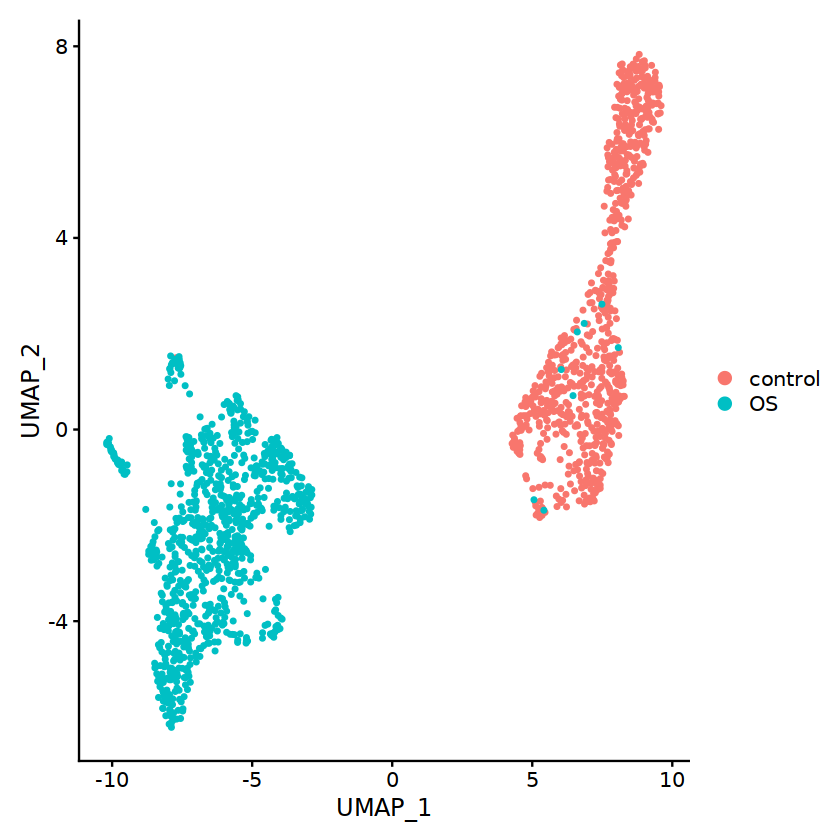

In [19]:
Idents(scRNA_harmony) = 'group'
DimPlot(scRNA_harmony)

In [21]:
options(repr.plot.width = 10,repr.plot.height = 12)

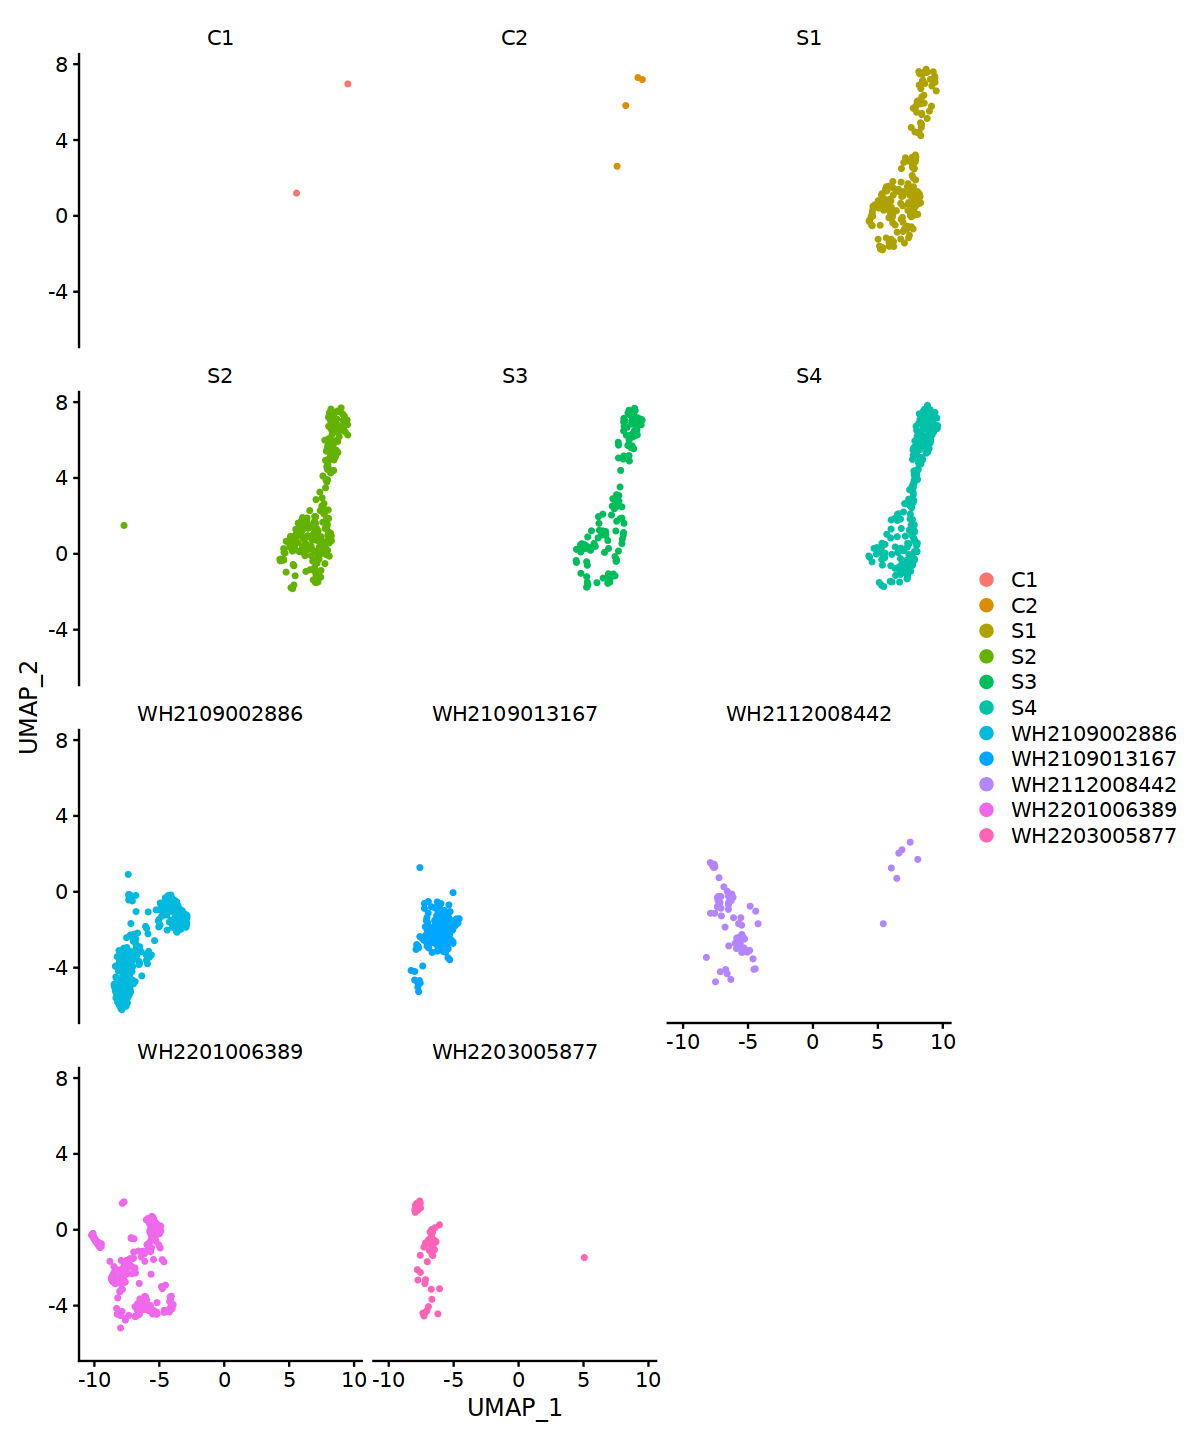

In [22]:
Idents(scRNA_harmony) = 'sample'
DimPlot(scRNA_harmony,split.by = 'sample',ncol = 3)

### 分成 normal bmsc  inter bmsc  tumor bmsc

### geakegg

In [23]:
sce = scRNA_harmony

In [24]:
DefaultAssay(sce) = 'RNA'

In [25]:
table(sce$cellgroup)


 Inter_BMSC normal_BMSC  tumor_BMSC 
        389         784         529 

In [26]:
Idents(sce)='cellgroup'
deg=FindMarkers(object = sce, ident.1 = 'tumor_BMSC',ident.2 = 'Inter_BMSC',
 min.pct = 0.01, logfc.threshold = 0.01,
 thresh.use = 0.99)
head(deg)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDKN2A,9.025922e-121,2.230929,0.883,0.075,1.566900e-116
POSTN,1.700615e-109,-2.378263,0.066,0.776,2.952268e-105
IGFBP7,2.500815e-78,-1.644919,0.391,0.861,4.341416e-74
THY1,8.258555e-66,-1.713901,0.253,0.728,1.433685e-61
TIMP3,1.190564e-57,-1.698616,0.070,0.524,2.066820e-53
CAV1,1.737138e-56,-1.787883,0.153,0.596,3.015671e-52


In [27]:
padj = 0.05
foldChange = 1

In [28]:
deg$group = as.factor(ifelse(deg$p_val_adj < padj & abs(deg$avg_log2FC) >= foldChange, 
                                 ifelse(deg$avg_log2FC> foldChange ,'Up','Down'),'NoSignifi'))

In [29]:
table(deg$group)


     Down NoSignifi        Up 
       57     14620        23 

In [30]:
res = deg

In [31]:
library(dplyr)

In [32]:
top_5 <- bind_rows(   
      res %>%
        filter(group == 'Up') %>%
        arrange(p_val_adj, desc(avg_log2FC)) %>%
        head(10),
      res %>%
        filter(group == 'Down') %>%
        arrange(p_val_adj, desc(avg_log2FC)) %>%
        head(10)
    )

In [33]:
library(ggpubr)
library(ggplot2)
    library(dplyr)
    library(ggrepel)
    library(ggplot2)
    library(cowplot)

Warning message:
"package 'ggpubr' was built under R version 4.2.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Warning message:
"package 'cowplot' was built under R version 4.2.3"

Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




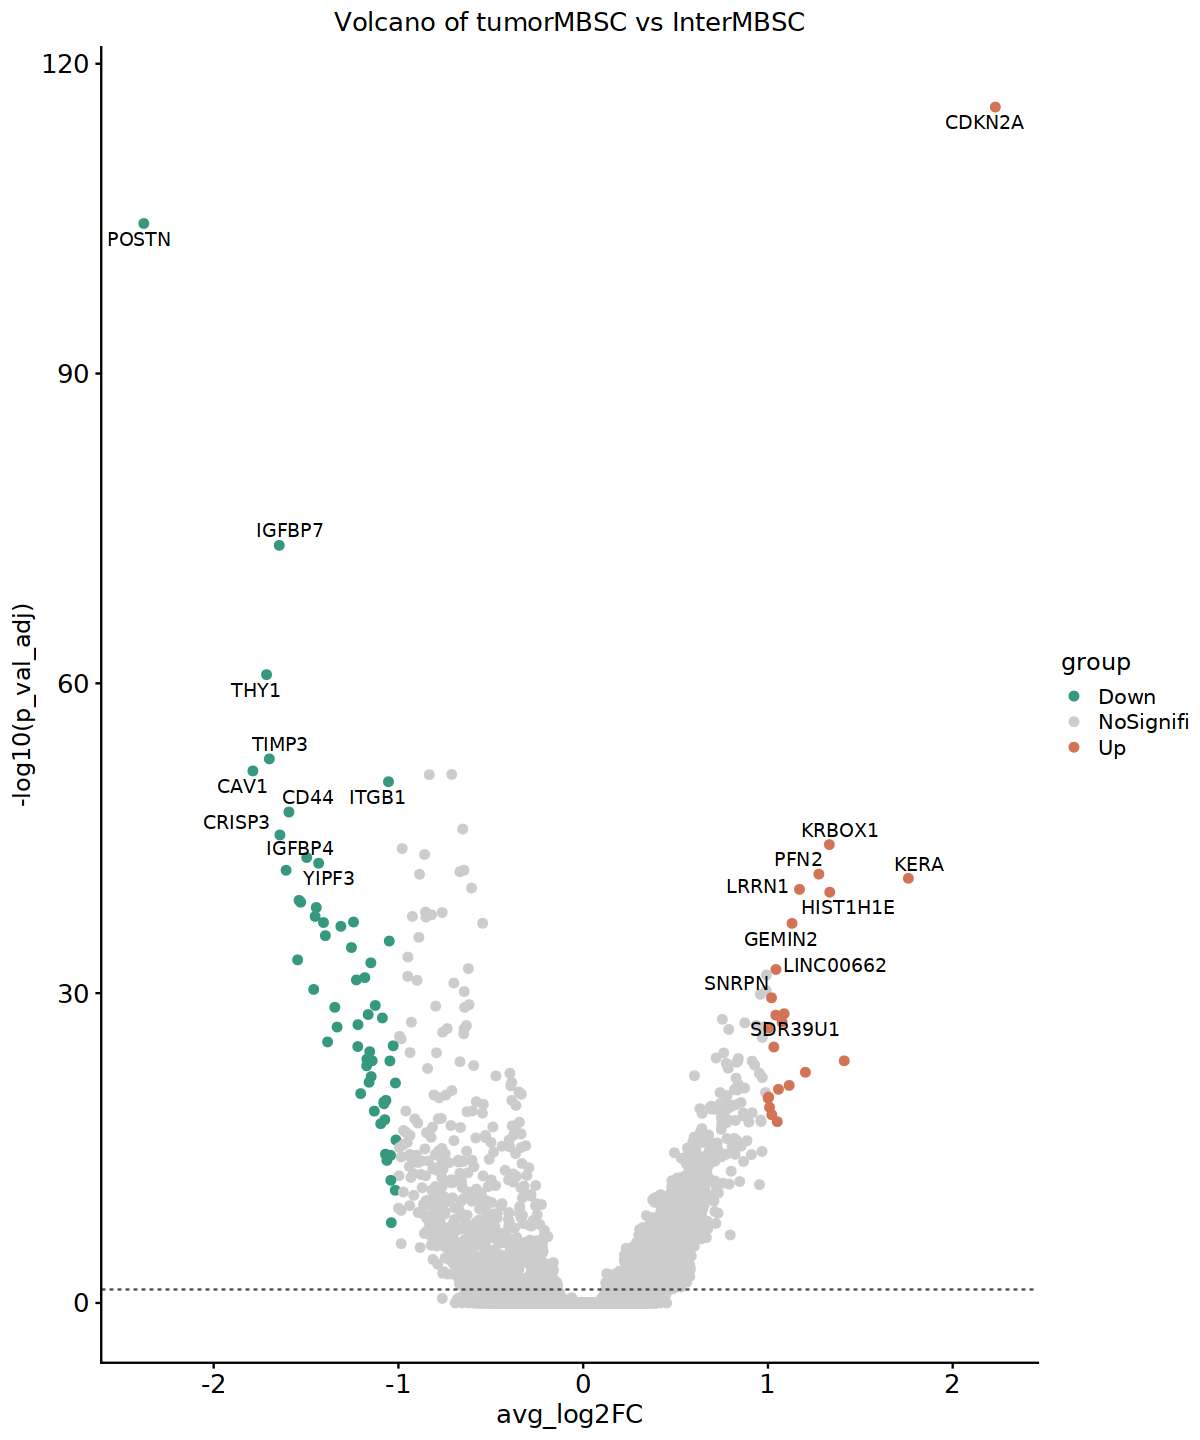

In [35]:

    ggplot(data=res,aes(x=avg_log2FC,y=-log10(p_val_adj)))+
    geom_point(aes(color=group),size=2)+
    geom_hline(yintercept = -log10(0.05), linetype="dashed",color="grey30")+
    #geom_vline(xintercept = c(-.8,.8),linetype="dashed",color="grey30")+
    geom_text_repel(data=top_5,aes(x= avg_log2FC,y= -log10(p_val_adj),label= rownames(top_5)),max.overlaps = 100)+
    scale_color_manual(values = c("#35987F","grey80","#D27356"))+
    theme_half_open() +
  theme(axis.title.x = element_text(size = 15))+
  theme(axis.text.x = element_text(size = 15))+
  theme(axis.text.y = element_text(size = 15))+
  theme(plot.title = element_text(size = 15,face = 4, hjust =0.5))+
  ggtitle("Volcano of tumorMBSC vs InterMBSC") 
    ggsave('Volcano.pdf',height = 8,width = 8)
    
   

In [36]:
diffgene = deg

In [37]:
library(clusterProfiler)
library(enrichplot)
library(org.Mm.eg.db)
#为每个基因添加对应的ENTREZID
diffgene$gene <- rownames(diffgene)
ids=bitr(diffgene$gene,'SYMBOL','ENTREZID','org.Hs.eg.db')
#合并数据，cluser3.markers中没有ENTREZID的基因将被过虑掉
diffgene=merge(diffgene,ids,by.x='gene',by.y='SYMBOL')

head(diffgene)

cluster3.markers = diffgene

#将基因按照avg_log2FC的大小进行降序排列
cluster3.markers <- cluster3.markers[order(cluster3.markers$avg_log2FC,decreasing = T),]
#生成仅含有ENTREZID名字和avg_log2FC值的gene list
cluster3.markers_list <- as.numeric(cluster3.markers$avg_log2FC)
names(cluster3.markers_list) <- cluster3.markers$ENTREZID
head(cluster3.markers_list)

#筛选差异较大的基因集
cluster3_de <- names(cluster3.markers_list)[abs(cluster3.markers_list) > 0.15]
head(cluster3_de)

length(cluster3_de)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

,gene,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,group,ENTREZID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,A1BG,4.747602e-13,0.51553143,0.270,0.077,8.241836e-09,NoSignifi,1
2,A1BG-AS1,2.539367e-04,0.16044408,0.057,0.010,1.000000e+00,NoSignifi,503538
3,A2M,7.607856e-01,-0.29290427,0.238,0.226,1.000000e+00,NoSignifi,2
4,A2M-AS1,9.791910e-03,0.05154809,0.017,0.000,1.000000e+00,NoSignifi,144571
5,A4GALT,1.904796e-09,-0.28576880,0.002,0.072,3.306725e-05,NoSignifi,53947
6,AAAS,3.879016e-01,-0.01087864,0.223,0.195,1.000000e+00,NoSignifi,8086


1029     11081       761 100506243      5217     57633 
 2.230929  1.760194  1.412843  1.332278  1.275636  1.170737

[1] "1029"      "11081"     "761"       "100506243" "5217"      "57633"

[1] 6002

In [38]:
cluster3_gsekg <- gseKEGG(cluster3.markers_list,organism = "hsa",pvalueCutoff = 0.01)
#将富集结果按照NES绝对值降序排列
cluster3_gsekg_arrange <- arrange(cluster3_gsekg,desc(abs(NES)))
head(cluster3_gsekg_arrange)

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation."
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
hsa04512,hsa04512,ECM-receptor interaction,58,-0.7497167,-2.687968,1.000000e-10,1.116667e-08,8.491228e-09,1181,"tags=53%, list=9%, signal=49%",1311/3672/3685/6385/3339/961/3910/375790/3912/3381/948/3655/1277/3915/7060/3693/1278/1293/1280/1291/6382/1282/2335/1292/7058/3678/1284/3688/7057/6696/960
hsa04974,hsa04974,Protein digestion and absorption,52,-0.7064881,-2.497209,6.829033e-10,5.719315e-08,4.349016e-08,1160,"tags=50%, list=9%, signal=46%",5547/4311/1296/50509/7373/2006/1303/6520/1277/3783/1295/1294/1289/1278/1293/1290/1281/1280/1291/1282/80781/1292/1284/1301/1306/1300
hsa05144,hsa05144,Malaria,37,-0.7461651,-2.491789,1.474861e-08,6.175980e-07,4.696268e-07,1911,"tags=65%, list=14%, signal=56%",4035/2994/7040/2993/3039/1311/6401/2532/3553/3040/3576/948/6383/3043/7060/3569/6347/7412/3082/975/6382/7058/7057/2995
hsa04510,hsa04510,Focal adhesion,159,-0.5702135,-2.414752,1.000000e-10,1.116667e-08,8.491228e-09,1181,"tags=33%, list=9%, signal=30%",1311/1398/9564/3672/3725/3685/60/207/3910/5296/3912/3381/7422/103910/7408/3655/5499/824/7791/29780/1277/3915/7060/55742/56034/3693/896/81/1278/3082/1293/1280/1291/330/1282/7423/7424/5159/2335/10627/1292/7058/3678/1284/2012/3688/7057/10398/858/595/6696/857
hsa04820,hsa04820,Cytoskeleton in muscle cells,159,-0.5555779,-2.352773,1.000000e-10,1.116667e-08,8.491228e-09,1516,"tags=36%, list=11%, signal=32%",4635/5339/4000/8910/23345/8515/72/7171/1311/10611/3672/3685/64423/60/6385/7431/3339/2200/50509/2006/375790/6383/2274/3655/7791/23500/6711/8082/1634/1277/7060/3693/25777/1465/1289/1278/1293/1290/1281/4627/1291/6382/633/1282/9260/2335/2192/1292/7058/3678/1284/2199/3688/7057/10398/1301/27295
hsa04145,hsa04145,Phagosome,108,-0.5636122,-2.251498,3.085956e-09,2.067591e-07,1.572213e-07,1898,"tags=39%, list=14%, signal=34%",9550/8417/84790/71/5879/7846/526/10952/6890/9554/3916/10376/8992/1311/3685/60/84617/9341/533/3117/10312/527/821/811/948/3133/3920/1535/7060/3122/3693/7280/1514/715/9902/3105/3107/3106/7058/3678/3688/7057


In [39]:
df = cluster3_gsekg_arrange@result

In [40]:
library(ggplot2)
library(ggstatsplot)

Warning message:
"package 'ggstatsplot' was built under R version 4.2.3"
You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167



In [41]:
options(repr.plot.width = 12,repr.plot.height = 5)

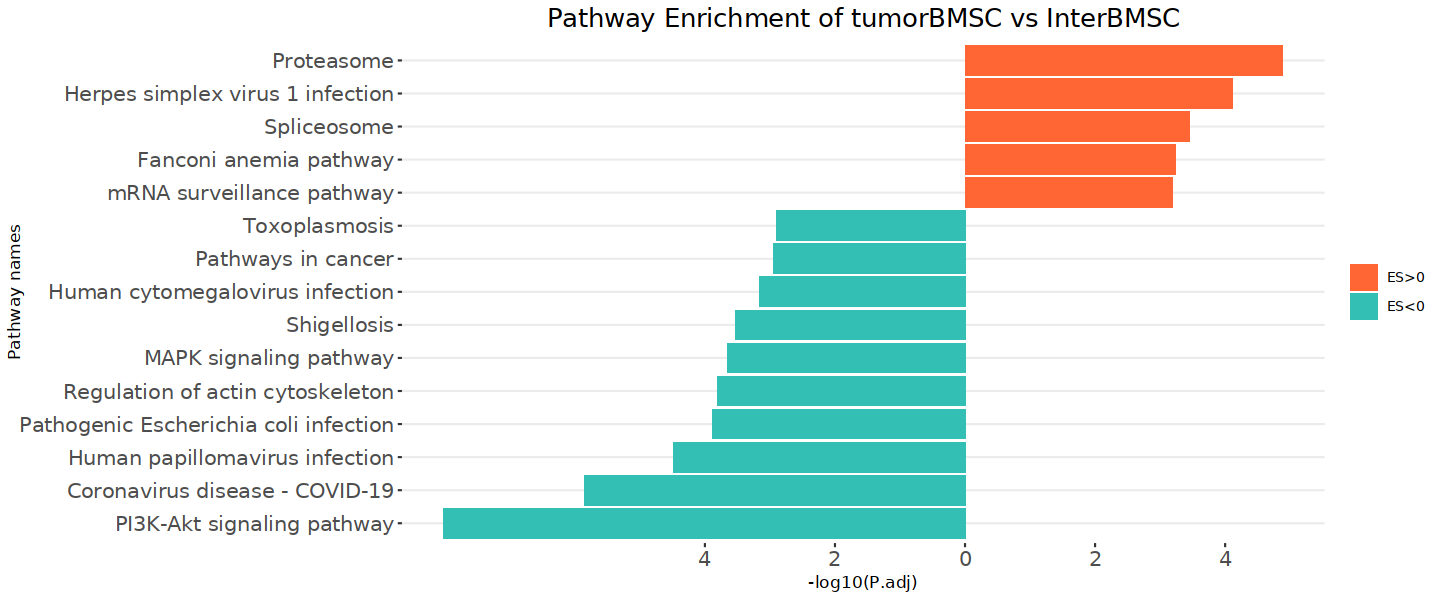

In [42]:
df = df[order(df$enrichmentScore),]
#设定分组：1--ES>0;   -1--ES<0
up = head(subset(df, enrichmentScore>0),10);up$group=1
down = tail(subset(df, enrichmentScore<0),10);down$group=-1
dat=rbind(up,down)
#dat$group = factor(dat$group);str(dat)
dat$pvalue = -log10(dat$pvalue)
dat$pvalue=dat$pvalue*dat$group 
dat=dat[order(dat$pvalue,decreasing = F),]
ggplot(dat, aes(x=reorder(Description,order(pvalue, decreasing = F)), y=pvalue, fill=group)) + 
  geom_bar(stat="identity", aes(fill=factor(group, levels = c(1,-1),  
                                            labels = c("ES>0","ES<0")))) + 
  xlab("Pathway names") +
  ylab("-log10(P.adj)") +
  coord_flip() + 
  theme_ggstatsplot() +
  scale_y_continuous(breaks=c(-4, -2, 0, 2, 4),
                     labels=c("4", "2", "0","2","4")) +
  scale_fill_manual(values = c("#ff6633","#34bfb5")) + 
  theme(plot.title = element_text(size = 15,hjust = 0.5),  
        axis.text = element_text(size = 12,face = 'bold'),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.title = element_blank()) +
  ggtitle("Pathway Enrichment of tumorBMSC vs InterBMSC") 